In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:

import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import csv
import time


# In[2]:


# Task Class based on "TaskID"
class Task(): 

    # add one ground with initiation
    def __init__(self, task_id, x, y, area): 
        self.x_array = np.empty(shape = (0), dtype = 'float64')
        self.y_array = np.empty(shape = (0), dtype = 'float64')
        self.area_array = np.empty(shape = (0), dtype = 'float64')

        self.taskid = task_id
        self.ground_count = 0
        self.ground_total_area = 0
        self.add_ground(x, y, area)

    # add Ground component
    def add_ground(self, x, y, area): 
        self.x_array = np.append(self.x_array, x)
        self.y_array = np.append(self.y_array, y)
        self.area_array = np.append(self.area_array, area)
        
        self.ground_count += 1
        self.ground_total_area += area

    def get_taskid(self):
        return self.taskid

    def get_ground_count(self):
        return self.ground_count

    def get_ground_total_area(self):
        return self.ground_total_area

    
    def print(self):
        print('TaskID:', self.taskid)
        #for i in range(0, self.ground_count):
        #    print('x: ', self.x_array[i], ' / y: ', self.y_array[i], ' / area: ', self.area_array[i])
        print('This Task has', self.ground_count, 'grounds.')
        print('Total area of this Task is:', self.ground_total_area, 'm^2')
        print('End of data.\n\n')


# In[3]:


class K_means():
    def __init__(self, Task, cycle = 10):
        self.cycle = cycle
        self.variation = -1.0

        self.k = 3
        self.data_size = Task.ground_count
        self.data_array = np.zeros(shape = (self.data_size, 4), dtype = 'float64')
        self.minimum_area = 33057.8512
        self.error_count = 0

        self.data_array[:, 0] = Task.x_array.copy()
        self.data_array[:, 1] = Task.y_array.copy()
        self.data_array[:, 2] = Task.area_array.copy()

        #self.old_centers = np.empty(shape = (self.k, 2), dtype = 'float64')
        self.old_total_area = np.empty(shape = (0), dtype = 'float64')

    def set_random_points(self):
        self.centers = np.empty(shape = (self.k, 2), dtype = 'float64')

        i = 0
        temp_list = []
        # there must not be duplicated centers.
        while i < self.k:
            flag = False
            temp = random.randrange(0, self.data_size)
            for j in temp_list: #if duplicated.
                if j == temp:
                    flag = True
                    break
            if not flag:
                temp_list.append(temp) #else
                i += 1

        i = 0
        for number in temp_list: # make centers array
            self.centers[i][0] = self.data_array[number][0]
            self.centers[i][1] = self.data_array[number][1]
            i += 1

    def clustering(self):
        for i in range(0, self.data_size):
            temp1 = -1.0
            record = 0
            for j in range(0, self.k):
                x = self.data_array[i][0]
                y = self.data_array[i][1]

                tx = self.centers[j][0]
                ty = self.centers[j][1]
                
                temp2 = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

                if temp1 == -1.0 or temp1 > temp2:
                    temp1 = temp2
                    record = j

            self.data_array[i][3] = record

    def center_adjusting(self):
        temp_array = np.zeros(shape = (self.k, 3), dtype = 'float64')

        #sum all of x and y value and count
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])

            temp_array[temp][0] += self.data_array[i][0]
            temp_array[temp][1] += self.data_array[i][1]
            temp_array[temp][2] += 1

        # devide all of x and y to count
        for i in range(0, self.k):
            #if one of groups has 0 count of ground.
            #means, that group has disappeared.
            count = temp_array[i][2]
            if not count:
                return -1  #error code
            temp_array[i][0] /= count
            temp_array[i][1] /= count

        flag = False
        for i in range(0, self.k): # compare that center has moved
            if temp_array[i][0] != self.centers[i][0]:
                flag = True
                break
            if temp_array[i][1] != self.centers[i][1]:
                flag = True
                break

        if flag: #if it moved
            for i in range(0, self.k):
                self.centers[i][0] = temp_array[i][0]
                self.centers[i][1] = temp_array[i][1]
            return 1

        else: #else
            return 0

    def adjust_total_area(self):
        #sum all total_area of each groups.
        self.total_area = np.zeros(shape = (self.k), dtype = 'float64')   
        for i in range(0, self.data_size):
            self.total_area[int(self.data_array[i][3])] += self.data_array[i][2]

        # make 2di_array of distance between all dots and centers.
        distance_array = np.empty(shape = (self.k, self.data_size), dtype = 'float64')
        for i in range(0, self.k):
            tx = self.centers[i][0]
            ty = self.centers[i][1]
            for j in range(0, self.data_size):
                x = self.data_array[j][0]
                y = self.data_array[j][1]
                                
                distance_array[i][j] = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        # READ (README FILE/class K_means) to get more info.
        marker_array = np.zeros(shape = (self.data_size), dtype = int)

        flag = True
        while flag:
            temp_array = self.total_area.copy()
            for i in range(0, self.k):
                if self.total_area[i] < self.minimum_area:
                    record1 = -1
                    record2 = -1
                    while self.total_area[i] < self.minimum_area:
                        temp1 = -1.0
                        for j in range(0, self.data_size):
                            if int(self.data_array[j][3]) != i:
                                if not marker_array[j]:
                                    temp2 = distance_array[i][j]
                                    if temp1 == -1.0 or temp1 > temp2:
                                        temp1 = temp2
                                        record1 = j
                            else:
                                marker_array[j] = 1
                                
                        record2 = int(self.data_array[record1][3])
                        self.data_array[record1][3] = i
                        self.total_area[i] += self.data_array[record1][2]
                        self.total_area[record2] -= self.data_array[record1][2]

                        marker_array[record1] = 1
                        
                    self.data_array[record1][3] = record2
                    self.total_area[i] -= self.data_array[record1][2]
                    self.total_area[record2] += self.data_array[record1][2]

                    marker_array[record1] = 0

            for i in range(0, self.k):
                if temp_array[i] != self.total_area[i]:
                    flag = True
                    break
                
                else:
                    flag = False

    def calculate_variation(self, field = False):
        all_sum = 0.0
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])
            
            x = self.data_array[i][0]
            y = self.data_array[i][1]
            tx = self.centers[temp][0]
            ty = self.centers[temp][1]

            all_sum += ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        #if variation had changed, return 1
        if (self.variation == -1.0) or (self.variation > all_sum):
            self.variation = all_sum

            if field:
                self.old_total_area = self.total_area.copy()
            return 1
        
        #else, return 0
        return 0

    # calculate variation of "real devided  info."
    def get_default_variation(self):
        self.variation = -1.0
        self.set_random_points()
        self.center_adjusting()
        self.calculate_variation()
        return self.variation

    #normal k_means
    def random_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            self.set_random_points()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear.
            if flag != -1:
                # if variation change has occured.
                if self.calculate_variation():
                    i = 0
                #else
                else:
                    i += 1
            else:
                self.error_count += 1

        self.error_count = 0
        print('Variation:', self.variation, '\nthis time cycle number is:', count)

    # special kmeans with "considering area need."
    def special_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            count += 1
            self.set_random_points()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear. and there are more than 1group.
            if flag != -1 and self.k > 1:
                self.adjust_total_area()
                self.center_adjusting()
                # if variation change has occured.
                if self.calculate_variation(True):
                    i = 0
                #else
                else:
                    i += 1

        self.error_count = 0
        print('Group total area\n', self.old_total_area)
        print('\nVariation:', self.variation, '\nthis time cycle number is:', count)

    def get_x_array(self):
        return self.data_array[:, 0]
    
    def get_y_array(self):
        return self.data_array[:, 1]
    
    def get_group_array(self):
        return self.data_array[:, 3]
    
    def get_group_min_max_xy(self):
        # self.k rows
        # 4 columns (minX, minY, maxX, maxY)
        temp_array = np.zeros(shape = (self.k, 4), dtype = 'float64')
        for i in range(0, self.data_size):
            group_num = int(self.data_array[i, 3])
            if temp_array[group_num, 0] == 0:
                temp_array[group_num, 0] = self.data_array[i, 0]
                temp_array[group_num, 1] = self.data_array[i, 1]
                temp_array[group_num, 2] = self.data_array[i, 0]
                temp_array[group_num, 3] = self.data_array[i, 1]
                continue
            if temp_array[group_num, 0] > self.data_array[i, 0]:
                temp_array[group_num, 0] = self.data_array[i, 0]
            if temp_array[group_num, 1] > self.data_array[i, 1]:
                temp_array[group_num, 1] = self.data_array[i, 1]
            if temp_array[group_num, 2] < self.data_array[i, 0]:
                temp_array[group_num, 2] = self.data_array[i, 0]
            if temp_array[group_num, 3] < self.data_array[i, 1]:
                temp_array[group_num, 3] = self.data_array[i, 1]
                
        return temp_array


def read_csv(file_name):
    return_list = []
    
    f = open(file_name, 'r', encoding = 'utf-8')

    i = 0
    for row in csv.reader(f):
        if i == 0:
            i += 1
            continue

        flag = False
        taskid = 0
        try:
            x = float(row[0])
            y = float(row[1])
            area = float(row[2])
        except ValueError:
            print(f"Unable to convert to float: {row}")
            continue
            
        if x <= 129 and x >= 128 and y <= 37 and y >= 36:
            for task in return_list:
                if task.get_taskid() == taskid:
                    task.add_ground(x, y, area)
                    flag = True
                    break
            if not flag:
                return_list.append(Task(taskid, x, y, area))
            
        #if i == 1000:
        #    break
        i += 1
        
    print('Task set finished\n')

    return return_list


# In[5]:


task_list = []

task_list = read_csv('./sorted_data.csv')

f = open('result_sum.csv','a', newline='')
wr = csv.writer(f)

result_dict = {"Algorithm": "k-means"}
for task in task_list:
    kmeans = K_means(task)

    task.print()
    
    dv = kmeans.get_default_variation()
    print('This is default variation', dv)
    
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                        'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})
    
    print('\nRANDOM K_MEANS')
    start = time.time()
    kmeans.random_kmeans()
    time1 = time.time() - start
    print('it took', round(time1, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})

    print('\nSPECIAL K_MEANS')
    start = time.time()
    kmeans.special_kmeans()
    time2 = time.time() - start
    print('it took', round(time2, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
                scatter_kws = {"s": 10})

    plt.show(block = True)
    polygons = []
    for group_id in set(kmeans.get_group_array()):
        indices = np.where(kmeans.get_group_array() == group_id)
        polygons.append(
        list(zip(kmeans.get_x_array()[indices].tolist(), kmeans.get_y_array()[indices].tolist())))  # y coordinates

    result_dict[str(task.get_taskid())] = polygons
    print('========================================')

f.close()

with open('result.json', 'w') as fp:
    json.dump(result_dict, fp, indent=4)  # use indent=4 for pretty-printing



print("2018125042이석준")



Task set finished

TaskID: 0
This Task has 8456 grounds.
Total area of this Task is: 16621485.799999997 m^2
End of data.


This is default variation 2298.9057551687692

RANDOM K_MEANS
Variation: 12.650702512556384 
this time cycle number is: 0
it took 10.149 secs.
[[128.4424367   36.00001705 128.5877016   36.0462536 ]
 [128.3033111   36.00136268 128.4355489   36.08277773]
 [128.4856161   36.71912276 128.6936299   36.96697794]]

SPECIAL K_MEANS
Group total area
 [ 684560.         8545937.2        7390988.60000001]

Variation: 12.650702512556384 
this time cycle number is: 17
it took 11.927 secs.
[[128.5375556   36.83423864 128.6936299   36.96697794]
 [128.3033111   36.00001705 128.5877016   36.08277773]
 [128.4856161   36.71912276 128.6441689   36.89063013]]


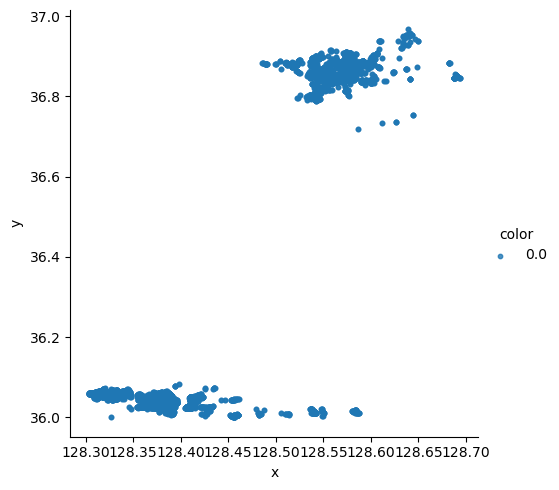

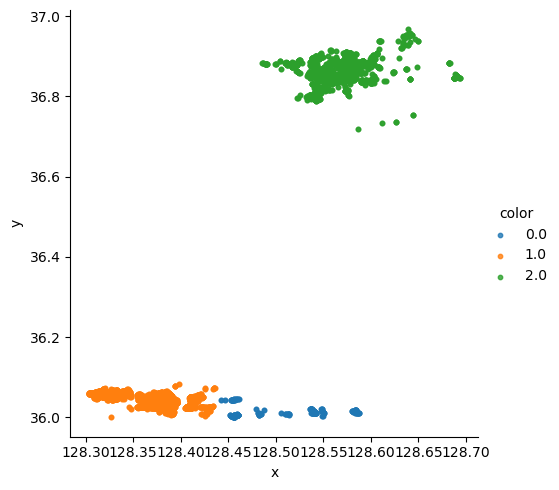

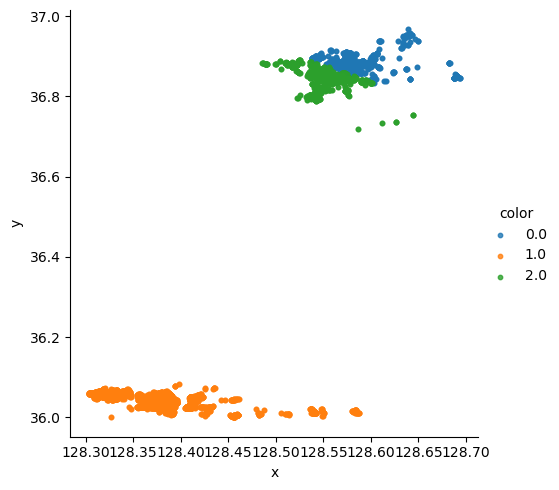

2018125042이석준


In [4]:
#최대평균거리를 이용한 알고리즘으로 초기 클러스터 중심을 선정
#!/usr/bin/env python
# coding: utf-8

# In[1]:

import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import csv
import time


# In[2]:


# Task Class based on "TaskID"
class Task(): 

    # add one ground with initiation
    def __init__(self, task_id, x, y, area): 
        self.x_array = np.empty(shape = (0), dtype = 'float64')
        self.y_array = np.empty(shape = (0), dtype = 'float64')
        self.area_array = np.empty(shape = (0), dtype = 'float64')

        self.taskid = task_id
        self.ground_count = 0
        self.ground_total_area = 0
        self.add_ground(x, y, area)

    # add Ground component
    def add_ground(self, x, y, area): 
        self.x_array = np.append(self.x_array, x)
        self.y_array = np.append(self.y_array, y)
        self.area_array = np.append(self.area_array, area)
        
        self.ground_count += 1
        self.ground_total_area += area

    def get_taskid(self):
        return self.taskid

    def get_ground_count(self):
        return self.ground_count

    def get_ground_total_area(self):
        return self.ground_total_area

    
    def print(self):
        print('TaskID:', self.taskid)
        #for i in range(0, self.ground_count):
        #    print('x: ', self.x_array[i], ' / y: ', self.y_array[i], ' / area: ', self.area_array[i])
        print('This Task has', self.ground_count, 'grounds.')
        print('Total area of this Task is:', self.ground_total_area, 'm^2')
        print('End of data.\n\n')


# In[3]:


class K_means():
    def __init__(self, Task, cycle = 10):
        self.cycle = cycle
        self.variation = -1.0

        self.k = 3
        self.data_size = Task.ground_count
        self.data_array = np.zeros(shape = (self.data_size, 4), dtype = 'float64')
        self.minimum_area = 33057.8512
        self.error_count = 0

        self.data_array[:, 0] = Task.x_array.copy()
        self.data_array[:, 1] = Task.y_array.copy()
        self.data_array[:, 2] = Task.area_array.copy()

        #self.old_centers = np.empty(shape = (self.k, 2), dtype = 'float64')
        self.old_total_area = np.empty(shape = (0), dtype = 'float64')

    def set_max_mean_distance_points(self):
        self.centers = np.empty(shape=(self.k, 4), dtype='float64')

        # select first center randomly
        initial_center_idx = random.randrange(0, self.data_size)
        self.centers[0] = self.data_array[initial_center_idx]

        for i in range(1, self.k):
            max_avg_distance = -1
            max_avg_distance_idx = -1
            for j in range(self.data_size):
                distance_to_centers = np.linalg.norm(self.data_array[j] - self.centers[:i], axis=1)
                avg_distance = np.mean(distance_to_centers)
                if avg_distance > max_avg_distance:
                    max_avg_distance = avg_distance
                    max_avg_distance_idx = j
            self.centers[i] = self.data_array[max_avg_distance_idx]

    def clustering(self):
        for i in range(0, self.data_size):
            temp1 = -1.0
            record = 0
            for j in range(0, self.k):
                x = self.data_array[i][0]
                y = self.data_array[i][1]

                tx = self.centers[j][0]
                ty = self.centers[j][1]
                
                temp2 = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

                if temp1 == -1.0 or temp1 > temp2:
                    temp1 = temp2
                    record = j

            self.data_array[i][3] = record

    def center_adjusting(self):
        temp_array = np.zeros(shape = (self.k, 3), dtype = 'float64')

        #sum all of x and y value and count
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])

            temp_array[temp][0] += self.data_array[i][0]
            temp_array[temp][1] += self.data_array[i][1]
            temp_array[temp][2] += 1

        # devide all of x and y to count
        for i in range(0, self.k):
            #if one of groups has 0 count of ground.
            #means, that group has disappeared.
            count = temp_array[i][2]
            if not count:
                return -1  #error code
            temp_array[i][0] /= count
            temp_array[i][1] /= count

        flag = False
        for i in range(0, self.k): # compare that center has moved
            if temp_array[i][0] != self.centers[i][0]:
                flag = True
                break
            if temp_array[i][1] != self.centers[i][1]:
                flag = True
                break

        if flag: #if it moved
            for i in range(0, self.k):
                self.centers[i][0] = temp_array[i][0]
                self.centers[i][1] = temp_array[i][1]
            return 1

        else: #else
            return 0

    def adjust_total_area(self):
        #sum all total_area of each groups.
        self.total_area = np.zeros(shape = (self.k), dtype = 'float64')   
        for i in range(0, self.data_size):
            self.total_area[int(self.data_array[i][3])] += self.data_array[i][2]

        # make 2di_array of distance between all dots and centers.
        distance_array = np.empty(shape = (self.k, self.data_size), dtype = 'float64')
        for i in range(0, self.k):
            tx = self.centers[i][0]
            ty = self.centers[i][1]
            for j in range(0, self.data_size):
                x = self.data_array[j][0]
                y = self.data_array[j][1]
                                
                distance_array[i][j] = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        # READ (README FILE/class K_means) to get more info.
        marker_array = np.zeros(shape = (self.data_size), dtype = int)

        flag = True
        while flag:
            temp_array = self.total_area.copy()
            for i in range(0, self.k):
                if self.total_area[i] < self.minimum_area:
                    record1 = -1
                    record2 = -1
                    while self.total_area[i] < self.minimum_area:
                        temp1 = -1.0
                        for j in range(0, self.data_size):
                            if int(self.data_array[j][3]) != i:
                                if not marker_array[j]:
                                    temp2 = distance_array[i][j]
                                    if temp1 == -1.0 or temp1 > temp2:
                                        temp1 = temp2
                                        record1 = j
                            else:
                                marker_array[j] = 1
                                
                        record2 = int(self.data_array[record1][3])
                        self.data_array[record1][3] = i
                        self.total_area[i] += self.data_array[record1][2]
                        self.total_area[record2] -= self.data_array[record1][2]

                        marker_array[record1] = 1
                        
                    self.data_array[record1][3] = record2
                    self.total_area[i] -= self.data_array[record1][2]
                    self.total_area[record2] += self.data_array[record1][2]

                    marker_array[record1] = 0

            for i in range(0, self.k):
                if temp_array[i] != self.total_area[i]:
                    flag = True
                    break
                
                else:
                    flag = False

    def calculate_variation(self, field = False):
        all_sum = 0.0
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])
            
            x = self.data_array[i][0]
            y = self.data_array[i][1]
            tx = self.centers[temp][0]
            ty = self.centers[temp][1]

            all_sum += ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        #if variation had changed, return 1
        if (self.variation == -1.0) or (self.variation > all_sum):
            self.variation = all_sum

            if field:
                self.old_total_area = self.total_area.copy()
            return 1
        
        #else, return 0
        return 0

    # calculate variation of "real devided  info."
    def get_default_variation(self):
        self.variation = -1.0
        self.set_max_mean_distance_points()
        self.center_adjusting()
        self.calculate_variation()
        return self.variation

    #normal k_means
    def random_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            self.set_max_mean_distance_points()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear.
            if flag != -1:
                # if variation change has occured.
                if self.calculate_variation():
                    i = 0
                #else
                else:
                    i += 1
            else:
                self.error_count += 1

        self.error_count = 0
        print('Variation:', self.variation, '\nthis time cycle number is:', count)

    # special kmeans with "considering area need."
    def special_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            count += 1
            self.set_max_mean_distance_points()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear. and there are more than 1group.
            if flag != -1 and self.k > 1:
                self.adjust_total_area()
                self.center_adjusting()
                # if variation change has occured.
                if self.calculate_variation(True):
                    i = 0
                #else
                else:
                    i += 1

        self.error_count = 0
        print('Group total area\n', self.old_total_area)
        print('\nVariation:', self.variation, '\nthis time cycle number is:', count)

    def get_x_array(self):
        return self.data_array[:, 0]
    
    def get_y_array(self):
        return self.data_array[:, 1]
    
    def get_group_array(self):
        return self.data_array[:, 3]
    
    def get_group_min_max_xy(self):
        # self.k rows
        # 4 columns (minX, minY, maxX, maxY)
        temp_array = np.zeros(shape = (self.k, 4), dtype = 'float64')
        for i in range(0, self.data_size):
            group_num = int(self.data_array[i, 3])
            if temp_array[group_num, 0] == 0:
                temp_array[group_num, 0] = self.data_array[i, 0]
                temp_array[group_num, 1] = self.data_array[i, 1]
                temp_array[group_num, 2] = self.data_array[i, 0]
                temp_array[group_num, 3] = self.data_array[i, 1]
                continue
            if temp_array[group_num, 0] > self.data_array[i, 0]:
                temp_array[group_num, 0] = self.data_array[i, 0]
            if temp_array[group_num, 1] > self.data_array[i, 1]:
                temp_array[group_num, 1] = self.data_array[i, 1]
            if temp_array[group_num, 2] < self.data_array[i, 0]:
                temp_array[group_num, 2] = self.data_array[i, 0]
            if temp_array[group_num, 3] < self.data_array[i, 1]:
                temp_array[group_num, 3] = self.data_array[i, 1]
                
        return temp_array



def read_csv(file_name):
    return_list = []
    
    f = open(file_name, 'r', encoding = 'utf-8')

    i = 0
    for row in csv.reader(f):
        if i == 0:
            i += 1
            continue

        flag = False
        taskid = 0
        try:
            x = float(row[0])
            y = float(row[1])
            area = float(row[2])
        except ValueError:
            print(f"Unable to convert to float: {row}")
            continue
            
        if x <= 129 and x >= 128 and y <= 37 and y >= 36:
            for task in return_list:
                if task.get_taskid() == taskid:
                    task.add_ground(x, y, area)
                    flag = True
                    break
            if not flag:
                return_list.append(Task(taskid, x, y, area))
            
        #if i == 1000:
        #    break
        i += 1
        
    print('Task set finished\n')

    return return_list


# In[5]:


task_list = []

task_list = read_csv('./sorted_data.csv')

f = open('result_sum.csv','a', newline='')
wr = csv.writer(f)

result_dict = {"Algorithm": "k-means"}
for task in task_list:
    kmeans = K_means(task)

    task.print()
    
    dv = kmeans.get_default_variation()
    print('This is default variation', dv)
    
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                        'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})
    
    print('\nRANDOM K_MEANS')
    start = time.time()
    kmeans.random_kmeans()
    time1 = time.time() - start
    print('it took', round(time1, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})

    print('\nSPECIAL K_MEANS')
    start = time.time()
    kmeans.special_kmeans()
    time2 = time.time() - start
    print('it took', round(time2, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
                scatter_kws = {"s": 10})

    plt.show(block = True)
    polygons = []
    for group_id in set(kmeans.get_group_array()):
        indices = np.where(kmeans.get_group_array() == group_id)
        polygons.append(
        list(zip(kmeans.get_x_array()[indices].tolist(), kmeans.get_y_array()[indices].tolist())))  # y coordinates

    result_dict[str(task.get_taskid())] = polygons
    print('========================================')

f.close()

with open('result.json', 'w') as fp:
    json.dump(result_dict, fp, indent=4)  # use indent=4 for pretty-printing



print("2018125042이석준")



Task set finished

TaskID: 0
This Task has 8456 grounds.
Total area of this Task is: 16621485.799999997 m^2
End of data.


This is default variation 2270.2269299898126

RANDOM K_MEANS


C:\Users\daek4\AppData\Local\Temp\ipykernel_14932\1245688725.py:99: RuntimeWarning: invalid value encountered in double_scalars
  triangle_height = np.linalg.norm(b - np.dot(a,b)/np.dot(a,a)*a)


Variation: 12.650702512556384 
this time cycle number is: 0
it took 8.527 secs.
[[128.4041341   36.00001705 128.5877016   36.0721034 ]
 [128.3033111   36.00136268 128.3979671   36.08277773]
 [128.4856161   36.71912276 128.6936299   36.96697794]]

SPECIAL K_MEANS
Group total area
 [ 684560.         7390988.60000001 8545937.2       ]

Variation: 12.650702512556384 
this time cycle number is: 13
it took 7.398 secs.
[[128.3033111   36.00136268 128.4355489   36.08277773]
 [128.4424367   36.00001705 128.5877016   36.0462536 ]
 [128.4856161   36.71912276 128.6936299   36.96697794]]


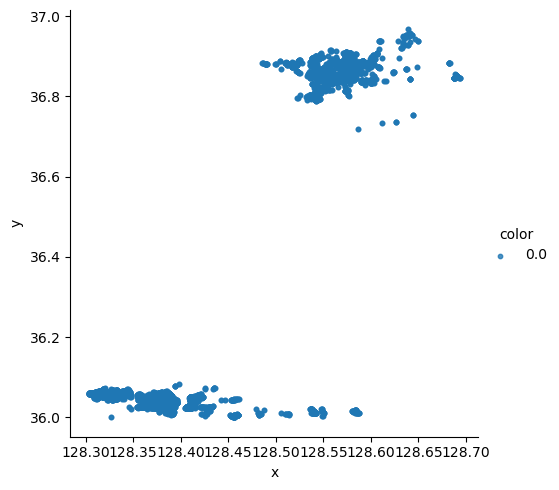

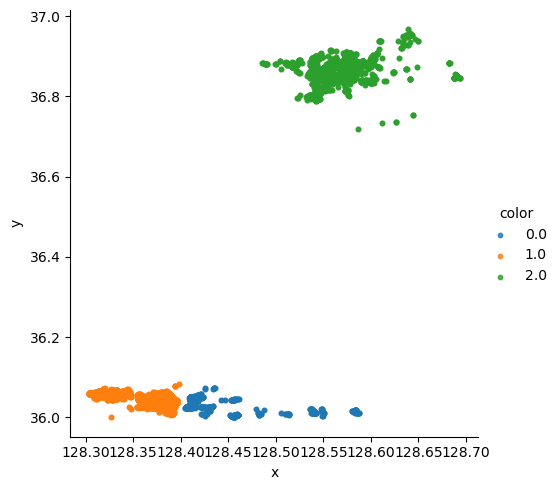

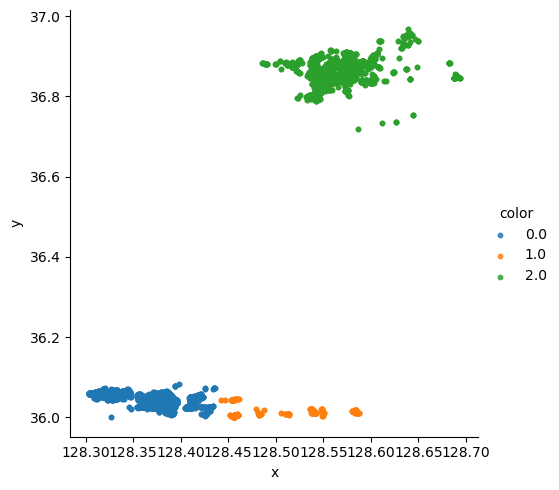

2018125042 이석준


In [4]:
#삼각형 높이를 이용한 알고리즘을 사용해서 초기 클러스터 중심을 선정
#!/usr/bin/env python
# coding: utf-8

# In[1]:

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import csv
import time


# In[2]:


# Task Class based on "TaskID"
class Task(): 

    # add one ground with initiation
    def __init__(self, task_id, x, y, area): 
        self.x_array = np.empty(shape = (0), dtype = 'float64')
        self.y_array = np.empty(shape = (0), dtype = 'float64')
        self.area_array = np.empty(shape = (0), dtype = 'float64')

        self.taskid = task_id
        self.ground_count = 0
        self.ground_total_area = 0
        self.add_ground(x, y, area)

    # add Ground component
    def add_ground(self, x, y, area): 
        self.x_array = np.append(self.x_array, x)
        self.y_array = np.append(self.y_array, y)
        self.area_array = np.append(self.area_array, area)
        
        self.ground_count += 1
        self.ground_total_area += area

    def get_taskid(self):
        return self.taskid

    def get_ground_count(self):
        return self.ground_count

    def get_ground_total_area(self):
        return self.ground_total_area

    
    def print(self):
        print('TaskID:', self.taskid)
        #for i in range(0, self.ground_count):
        #    print('x: ', self.x_array[i], ' / y: ', self.y_array[i], ' / area: ', self.area_array[i])
        print('This Task has', self.ground_count, 'grounds.')
        print('Total area of this Task is:', self.ground_total_area, 'm^2')
        print('End of data.\n\n')


# In[3]:


class K_means():
    def __init__(self, Task, cycle = 10):
        self.cycle = cycle
        self.variation = -1.0

        self.k = 3
        self.data_size = Task.ground_count
        self.data_array = np.zeros(shape = (self.data_size, 4), dtype = 'float64')
        self.minimum_area = 33057.8512
        self.error_count = 0

        self.data_array[:, 0] = Task.x_array.copy()
        self.data_array[:, 1] = Task.y_array.copy()
        self.data_array[:, 2] = Task.area_array.copy()

        #self.old_centers = np.empty(shape = (self.k, 2), dtype = 'float64')
        self.old_total_area = np.empty(shape = (0), dtype = 'float64')

    def set_triangle_height_points(self):
        self.centers = np.empty(shape=(self.k, 4), dtype='float64')

        # select first two centers randomly
        initial_centers_idx = random.sample(range(self.data_size), 2)
        self.centers[:2] = self.data_array[initial_centers_idx]

        for i in range(2, self.k):
            max_triangle_height = -1
            max_triangle_height_idx = -1

            for j in range(self.data_size):
                # get the distance from each point to the line segment defined by the current centers
                a = self.centers[i-1] - self.centers[i-2]
                b = self.data_array[j] - self.centers[i-2]
                triangle_height = np.linalg.norm(b - np.dot(a,b)/np.dot(a,a)*a)
                
                if triangle_height > max_triangle_height:
                    max_triangle_height = triangle_height
                    max_triangle_height_idx = j

            self.centers[i] = self.data_array[max_triangle_height_idx]


    def clustering(self):
        for i in range(0, self.data_size):
            temp1 = -1.0
            record = 0
            for j in range(0, self.k):
                x = self.data_array[i][0]
                y = self.data_array[i][1]

                tx = self.centers[j][0]
                ty = self.centers[j][1]
                
                temp2 = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

                if temp1 == -1.0 or temp1 > temp2:
                    temp1 = temp2
                    record = j

            self.data_array[i][3] = record

    def center_adjusting(self):
        temp_array = np.zeros(shape = (self.k, 3), dtype = 'float64')

        #sum all of x and y value and count
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])

            temp_array[temp][0] += self.data_array[i][0]
            temp_array[temp][1] += self.data_array[i][1]
            temp_array[temp][2] += 1

        # devide all of x and y to count
        for i in range(0, self.k):
            #if one of groups has 0 count of ground.
            #means, that group has disappeared.
            count = temp_array[i][2]
            if not count:
                return -1  #error code
            temp_array[i][0] /= count
            temp_array[i][1] /= count

        flag = False
        for i in range(0, self.k): # compare that center has moved
            if temp_array[i][0] != self.centers[i][0]:
                flag = True
                break
            if temp_array[i][1] != self.centers[i][1]:
                flag = True
                break

        if flag: #if it moved
            for i in range(0, self.k):
                self.centers[i][0] = temp_array[i][0]
                self.centers[i][1] = temp_array[i][1]
            return 1

        else: #else
            return 0

    def adjust_total_area(self):
        #sum all total_area of each groups.
        self.total_area = np.zeros(shape = (self.k), dtype = 'float64')   
        for i in range(0, self.data_size):
            self.total_area[int(self.data_array[i][3])] += self.data_array[i][2]

        # make 2di_array of distance between all dots and centers.
        distance_array = np.empty(shape = (self.k, self.data_size), dtype = 'float64')
        for i in range(0, self.k):
            tx = self.centers[i][0]
            ty = self.centers[i][1]
            for j in range(0, self.data_size):
                x = self.data_array[j][0]
                y = self.data_array[j][1]
                                
                distance_array[i][j] = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        # READ (README FILE/class K_means) to get more info.
        marker_array = np.zeros(shape = (self.data_size), dtype = int)

        flag = True
        while flag:
            temp_array = self.total_area.copy()
            for i in range(0, self.k):
                if self.total_area[i] < self.minimum_area:
                    record1 = -1
                    record2 = -1
                    while self.total_area[i] < self.minimum_area:
                        temp1 = -1.0
                        for j in range(0, self.data_size):
                            if int(self.data_array[j][3]) != i:
                                if not marker_array[j]:
                                    temp2 = distance_array[i][j]
                                    if temp1 == -1.0 or temp1 > temp2:
                                        temp1 = temp2
                                        record1 = j
                            else:
                                marker_array[j] = 1
                                
                        record2 = int(self.data_array[record1][3])
                        self.data_array[record1][3] = i
                        self.total_area[i] += self.data_array[record1][2]
                        self.total_area[record2] -= self.data_array[record1][2]

                        marker_array[record1] = 1
                        
                    self.data_array[record1][3] = record2
                    self.total_area[i] -= self.data_array[record1][2]
                    self.total_area[record2] += self.data_array[record1][2]

                    marker_array[record1] = 0

            for i in range(0, self.k):
                if temp_array[i] != self.total_area[i]:
                    flag = True
                    break
                
                else:
                    flag = False

    def calculate_variation(self, field = False):
        all_sum = 0.0
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])
            
            x = self.data_array[i][0]
            y = self.data_array[i][1]
            tx = self.centers[temp][0]
            ty = self.centers[temp][1]

            all_sum += ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        #if variation had changed, return 1
        if (self.variation == -1.0) or (self.variation > all_sum):
            self.variation = all_sum

            if field:
                self.old_total_area = self.total_area.copy()
            return 1
        
        #else, return 0
        return 0

    # calculate variation of "real devided  info."
    def get_default_variation(self):
        self.variation = -1.0
        self.set_triangle_height_points()
        self.center_adjusting()
        self.calculate_variation()
        return self.variation

    #normal k_means
    def random_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            self.set_triangle_height_points()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear.
            if flag != -1:
                # if variation change has occured.
                if self.calculate_variation():
                    i = 0
                #else
                else:
                    i += 1
            else:
                self.error_count += 1

        self.error_count = 0
        print('Variation:', self.variation, '\nthis time cycle number is:', count)

    # special kmeans with "considering area need."
    def special_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            count += 1
            self.set_triangle_height_points()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear. and there are more than 1group.
            if flag != -1 and self.k > 1:
                self.adjust_total_area()
                self.center_adjusting()
                # if variation change has occured.
                if self.calculate_variation(True):
                    i = 0
                #else
                else:
                    i += 1

        self.error_count = 0
        print('Group total area\n', self.old_total_area)
        print('\nVariation:', self.variation, '\nthis time cycle number is:', count)

    def get_x_array(self):
        return self.data_array[:, 0]
    
    def get_y_array(self):
        return self.data_array[:, 1]
    
    def get_group_array(self):
        return self.data_array[:, 3]
    
    def get_group_min_max_xy(self):
        # self.k rows
        # 4 columns (minX, minY, maxX, maxY)
        temp_array = np.zeros(shape = (self.k, 4), dtype = 'float64')
        for i in range(0, self.data_size):
            group_num = int(self.data_array[i, 3])
            if temp_array[group_num, 0] == 0:
                temp_array[group_num, 0] = self.data_array[i, 0]
                temp_array[group_num, 1] = self.data_array[i, 1]
                temp_array[group_num, 2] = self.data_array[i, 0]
                temp_array[group_num, 3] = self.data_array[i, 1]
                continue
            if temp_array[group_num, 0] > self.data_array[i, 0]:
                temp_array[group_num, 0] = self.data_array[i, 0]
            if temp_array[group_num, 1] > self.data_array[i, 1]:
                temp_array[group_num, 1] = self.data_array[i, 1]
            if temp_array[group_num, 2] < self.data_array[i, 0]:
                temp_array[group_num, 2] = self.data_array[i, 0]
            if temp_array[group_num, 3] < self.data_array[i, 1]:
                temp_array[group_num, 3] = self.data_array[i, 1]
                
        return temp_array


def read_csv(file_name):
    return_list = []
    
    f = open(file_name, 'r', encoding = 'utf-8')

    i = 0
    for row in csv.reader(f):
        if i == 0:
            i += 1
            continue

        flag = False
        taskid = 0
        try:
            x = float(row[0])
            y = float(row[1])
            area = float(row[2])
        except ValueError:
            print(f"Unable to convert to float: {row}")
            continue
            
        if x <= 129 and x >= 128 and y <= 37 and y >= 36:
            for task in return_list:
                if task.get_taskid() == taskid:
                    task.add_ground(x, y, area)
                    flag = True
                    break
            if not flag:
                return_list.append(Task(taskid, x, y, area))
            
        #if i == 1000:
        #    break
        i += 1
        
    print('Task set finished\n')

    return return_list


# In[5]:


task_list = []

task_list = read_csv('./sorted_data.csv')

f = open('result_sum.csv','a', newline='')
wr = csv.writer(f)

result_dict = {"Algorithm": "k-means"}
for task in task_list:
    kmeans = K_means(task)

    task.print()
    
    dv = kmeans.get_default_variation()
    print('This is default variation', dv)
    
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                        'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})
    
    print('\nRANDOM K_MEANS')
    start = time.time()
    kmeans.random_kmeans()
    time1 = time.time() - start
    print('it took', round(time1, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})

    print('\nSPECIAL K_MEANS')
    start = time.time()
    kmeans.special_kmeans()
    time2 = time.time() - start
    print('it took', round(time2, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
                scatter_kws = {"s": 10})

    plt.show(block = True)
    polygons = []
    for group_id in set(kmeans.get_group_array()):
        indices = np.where(kmeans.get_group_array() == group_id)
        polygons.append(
        list(zip(kmeans.get_x_array()[indices].tolist(), kmeans.get_y_array()[indices].tolist())))  # y coordinates

    result_dict[str(task.get_taskid())] = polygons
    print('========================================')

f.close()

with open('result.json', 'w') as fp:
    json.dump(result_dict, fp, indent=4)  # use indent=4 for pretty-printing



print("2018125042이석준")





Task set finished

TaskID: 0
This Task has 8456 grounds.
Total area of this Task is: 16621485.799999997 m^2
End of data.


This is default variation 3849.1063969969723

RANDOM K_MEANS
Variation: 12.650702512556384 
this time cycle number is: 0
it took 4.677 secs.
[[128.4424367   36.00001705 128.5877016   36.0462536 ]
 [128.4856161   36.71912276 128.6936299   36.96697794]
 [128.3033111   36.00136268 128.4355489   36.08277773]]

SPECIAL K_MEANS
Group total area
 [8545937.2        7390988.60000001  684560.        ]

Variation: 12.650702512556384 
this time cycle number is: 20
it took 9.244 secs.
[[128.3033111   36.00136268 128.4355489   36.08277773]
 [128.4856161   36.71912276 128.6936299   36.96697794]
 [128.4424367   36.00001705 128.5877016   36.0462536 ]]


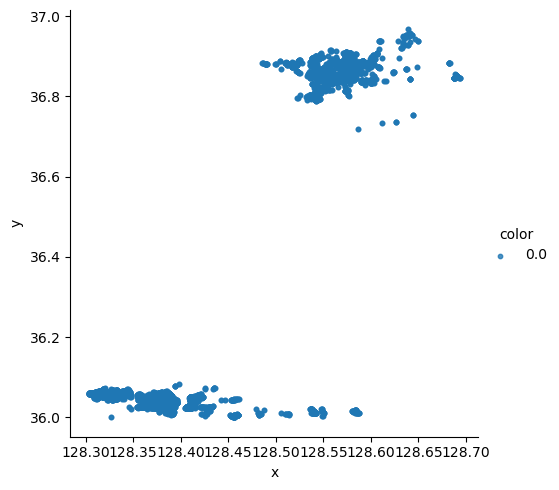

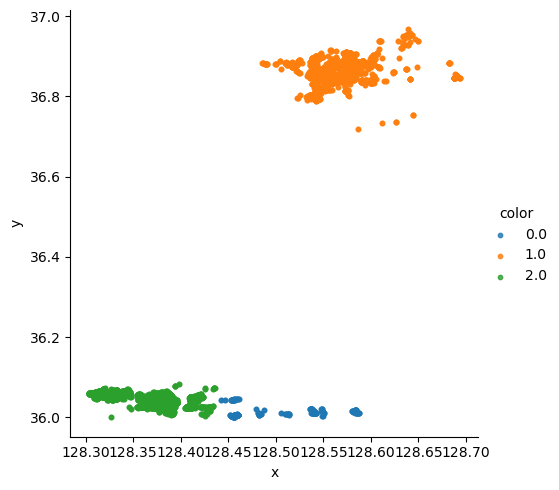

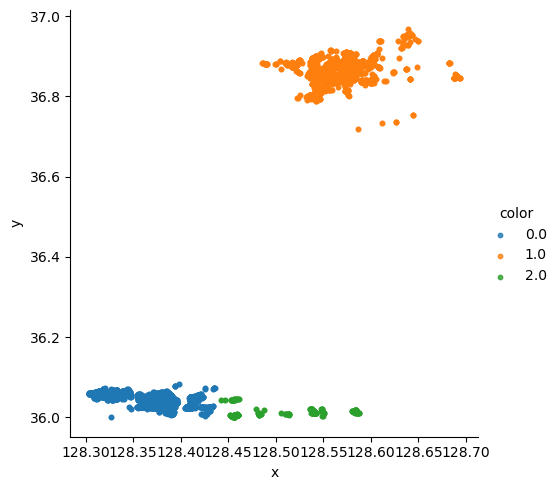

2018125042 이석준


In [5]:
#!/usr/bin/env python
# coding: utf-8
#
# In[1]:

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import csv
import time


# In[2]:


# Task Class based on "TaskID"
class Task(): 

    # add one ground with initiation
    def __init__(self, task_id, x, y, area): 
        self.x_array = np.empty(shape = (0), dtype = 'float64')
        self.y_array = np.empty(shape = (0), dtype = 'float64')
        self.area_array = np.empty(shape = (0), dtype = 'float64')

        self.taskid = task_id
        self.ground_count = 0
        self.ground_total_area = 0
        self.add_ground(x, y, area)

    # add Ground component
    def add_ground(self, x, y, area): 
        self.x_array = np.append(self.x_array, x)
        self.y_array = np.append(self.y_array, y)
        self.area_array = np.append(self.area_array, area)
        
        self.ground_count += 1
        self.ground_total_area += area

    def get_taskid(self):
        return self.taskid

    def get_ground_count(self):
        return self.ground_count

    def get_ground_total_area(self):
        return self.ground_total_area

    
    def print(self):
        print('TaskID:', self.taskid)
        #for i in range(0, self.ground_count):
        #    print('x: ', self.x_array[i], ' / y: ', self.y_array[i], ' / area: ', self.area_array[i])
        print('This Task has', self.ground_count, 'grounds.')
        print('Total area of this Task is:', self.ground_total_area, 'm^2')
        print('End of data.\n\n')


# In[3]:


class K_means():
    def __init__(self, Task, cycle = 10):
        self.cycle = cycle
        self.variation = -1.0

        self.k = 3
        self.data_size = Task.ground_count
        self.data_array = np.zeros(shape = (self.data_size, 4), dtype = 'float64')
        self.minimum_area = 33057.8512
        self.error_count = 0

        self.data_array[:, 0] = Task.x_array.copy()
        self.data_array[:, 1] = Task.y_array.copy()
        self.data_array[:, 2] = Task.area_array.copy()

        #self.old_centers = np.empty(shape = (self.k, 2), dtype = 'float64')
        self.old_total_area = np.empty(shape = (0), dtype = 'float64')

    def set_triangular_points(self):
        self.centers = np.empty(shape=(self.k, 4), dtype='float64')
    
    # 단계 1: 데이터에서 임의의 점을 첫 번째 중심점으로 선택합니다.
        first_center_index = np.random.choice(range(self.data_size))
        self.centers[0] = self.data_array[first_center_index]
    
    # 2.첫 번째 중심점으로부터 가장 멀리 떨어진 점을 두 번째 중심점으로 선택합니다.
        dist_from_first_center = np.linalg.norm(self.data_array - self.centers[0], axis=1)
        second_center_index = np.argmax(dist_from_first_center)
        self.centers[1] = self.data_array[second_center_index]
    
    # 3. 첫 번째와 두 번째 중심점으로부터 가장 멀리 떨어진 점을 세 번째 중심점으로 선택합니다.
        dist_from_second_center = np.linalg.norm(self.data_array - self.centers[1], axis=1)
        min_dist_from_both_centers = np.minimum(dist_from_first_center, dist_from_second_center)
        third_center_index = np.argmax(min_dist_from_both_centers)
        self.centers[2] = self.data_array[third_center_index]

    def clustering(self):
        for i in range(0, self.data_size):
            temp1 = -1.0
            record = 0
            for j in range(0, self.k):
                x = self.data_array[i][0]
                y = self.data_array[i][1]

                tx = self.centers[j][0]
                ty = self.centers[j][1]
                
                temp2 = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

                if temp1 == -1.0 or temp1 > temp2:
                    temp1 = temp2
                    record = j

            self.data_array[i][3] = record

    def center_adjusting(self):
        temp_array = np.zeros(shape = (self.k, 3), dtype = 'float64')

        #sum all of x and y value and count
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])

            temp_array[temp][0] += self.data_array[i][0]
            temp_array[temp][1] += self.data_array[i][1]
            temp_array[temp][2] += 1

        # devide all of x and y to count
        for i in range(0, self.k):
            #if one of groups has 0 count of ground.
            #means, that group has disappeared.
            count = temp_array[i][2]
            if not count:
                return -1  #error code
            temp_array[i][0] /= count
            temp_array[i][1] /= count

        flag = False
        for i in range(0, self.k): # compare that center has moved
            if temp_array[i][0] != self.centers[i][0]:
                flag = True
                break
            if temp_array[i][1] != self.centers[i][1]:
                flag = True
                break

        if flag: #if it moved
            for i in range(0, self.k):
                self.centers[i][0] = temp_array[i][0]
                self.centers[i][1] = temp_array[i][1]
            return 1

        else: #else
            return 0

    def adjust_total_area(self):
        #sum all total_area of each groups.
        self.total_area = np.zeros(shape = (self.k), dtype = 'float64')   
        for i in range(0, self.data_size):
            self.total_area[int(self.data_array[i][3])] += self.data_array[i][2]

        # make 2di_array of distance between all dots and centers.
        distance_array = np.empty(shape = (self.k, self.data_size), dtype = 'float64')
        for i in range(0, self.k):
            tx = self.centers[i][0]
            ty = self.centers[i][1]
            for j in range(0, self.data_size):
                x = self.data_array[j][0]
                y = self.data_array[j][1]
                                
                distance_array[i][j] = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        # READ (README FILE/class K_means) to get more info.
        marker_array = np.zeros(shape = (self.data_size), dtype = int)

        flag = True
        while flag:
            temp_array = self.total_area.copy()
            for i in range(0, self.k):
                if self.total_area[i] < self.minimum_area:
                    record1 = -1
                    record2 = -1
                    while self.total_area[i] < self.minimum_area:
                        temp1 = -1.0
                        for j in range(0, self.data_size):
                            if int(self.data_array[j][3]) != i:
                                if not marker_array[j]:
                                    temp2 = distance_array[i][j]
                                    if temp1 == -1.0 or temp1 > temp2:
                                        temp1 = temp2
                                        record1 = j
                            else:
                                marker_array[j] = 1
                                
                        record2 = int(self.data_array[record1][3])
                        self.data_array[record1][3] = i
                        self.total_area[i] += self.data_array[record1][2]
                        self.total_area[record2] -= self.data_array[record1][2]

                        marker_array[record1] = 1
                        
                    self.data_array[record1][3] = record2
                    self.total_area[i] -= self.data_array[record1][2]
                    self.total_area[record2] += self.data_array[record1][2]

                    marker_array[record1] = 0

            for i in range(0, self.k):
                if temp_array[i] != self.total_area[i]:
                    flag = True
                    break
                
                else:
                    flag = False

    def calculate_variation(self, field = False):
        all_sum = 0.0
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])
            
            x = self.data_array[i][0]
            y = self.data_array[i][1]
            tx = self.centers[temp][0]
            ty = self.centers[temp][1]

            all_sum += ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        #if variation had changed, return 1
        if (self.variation == -1.0) or (self.variation > all_sum):
            self.variation = all_sum

            if field:
                self.old_total_area = self.total_area.copy()
            return 1
        
        #else, return 0
        return 0

    # calculate variation of "real devided  info."
    def get_default_variation(self):
        self.variation = -1.0
        self.set_triangular_points()
        self.center_adjusting()
        self.calculate_variation()
        return self.variation

    #normal k_means
    def random_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            self.set_triangular_points()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear.
            if flag != -1:
                # if variation change has occured.
                if self.calculate_variation():
                    i = 0
                #else
                else:
                    i += 1
            else:
                self.error_count += 1

        self.error_count = 0
        print('Variation:', self.variation, '\nthis time cycle number is:', count)

    # special kmeans with "considering area need."
    def special_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            count += 1
            self.set_triangular_points()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear. and there are more than 1group.
            if flag != -1 and self.k > 1:
                self.adjust_total_area()
                self.center_adjusting()
                # if variation change has occured.
                if self.calculate_variation(True):
                    i = 0
                #else
                else:
                    i += 1

        self.error_count = 0
        print('Group total area\n', self.old_total_area)
        print('\nVariation:', self.variation, '\nthis time cycle number is:', count)

    def get_x_array(self):
        return self.data_array[:, 0]
    
    def get_y_array(self):
        return self.data_array[:, 1]
    
    def get_group_array(self):
        return self.data_array[:, 3]
    
    def get_group_min_max_xy(self):
        # self.k rows
        # 4 columns (minX, minY, maxX, maxY)
        temp_array = np.zeros(shape = (self.k, 4), dtype = 'float64')
        for i in range(0, self.data_size):
            group_num = int(self.data_array[i, 3])
            if temp_array[group_num, 0] == 0:
                temp_array[group_num, 0] = self.data_array[i, 0]
                temp_array[group_num, 1] = self.data_array[i, 1]
                temp_array[group_num, 2] = self.data_array[i, 0]
                temp_array[group_num, 3] = self.data_array[i, 1]
                continue
            if temp_array[group_num, 0] > self.data_array[i, 0]:
                temp_array[group_num, 0] = self.data_array[i, 0]
            if temp_array[group_num, 1] > self.data_array[i, 1]:
                temp_array[group_num, 1] = self.data_array[i, 1]
            if temp_array[group_num, 2] < self.data_array[i, 0]:
                temp_array[group_num, 2] = self.data_array[i, 0]
            if temp_array[group_num, 3] < self.data_array[i, 1]:
                temp_array[group_num, 3] = self.data_array[i, 1]
                
        return temp_array


# In[4]:



def read_csv(file_name):
    return_list = []
    
    f = open(file_name, 'r', encoding = 'utf-8')

    i = 0
    for row in csv.reader(f):
        if i == 0:
            i += 1
            continue

        flag = False
        taskid = 0
        try:
            x = float(row[0])
            y = float(row[1])
            area = float(row[2])
        except ValueError:
            print(f"Unable to convert to float: {row}")
            continue
            
        if x <= 129 and x >= 128 and y <= 37 and y >= 36:
            for task in return_list:
                if task.get_taskid() == taskid:
                    task.add_ground(x, y, area)
                    flag = True
                    break
            if not flag:
                return_list.append(Task(taskid, x, y, area))
            
        #if i == 1000:
        #    break
        i += 1
        
    print('Task set finished\n')

    return return_list


# In[5]:


task_list = []

task_list = read_csv('./sorted_data.csv')

f = open('result_sum.csv','a', newline='')
wr = csv.writer(f)

result_dict = {"Algorithm": "k-means"}
for task in task_list:
    kmeans = K_means(task)

    task.print()
    
    dv = kmeans.get_default_variation()
    print('This is default variation', dv)
    
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                        'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})
    
    print('\nRANDOM K_MEANS')
    start = time.time()
    kmeans.random_kmeans()
    time1 = time.time() - start
    print('it took', round(time1, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})

    print('\nSPECIAL K_MEANS')
    start = time.time()
    kmeans.special_kmeans()
    time2 = time.time() - start
    print('it took', round(time2, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
                scatter_kws = {"s": 10})

    plt.show(block = True)
    polygons = []
    for group_id in set(kmeans.get_group_array()):
        indices = np.where(kmeans.get_group_array() == group_id)
        polygons.append(
        list(zip(kmeans.get_x_array()[indices].tolist(), kmeans.get_y_array()[indices].tolist())))  # y coordinates

    result_dict[str(task.get_taskid())] = polygons
    print('========================================')

f.close()

with open('result.json', 'w') as fp:
    json.dump(result_dict, fp, indent=4)  # use indent=4 for pretty-printing



print("2018125042이석준")




Task set finished

TaskID: 0
This Task has 8456 grounds.
Total area of this Task is: 16621485.799999997 m^2
End of data.


This is default variation 2324.366134021364

RANDOM K_MEANS
Variation: 12.650702512556384 
this time cycle number is: 0
it took 6.3 secs.
[[128.4856161   36.71912276 128.6936299   36.96697794]
 [128.3033111   36.00136268 128.3979671   36.08277773]
 [128.4041341   36.00001705 128.5877016   36.0721034 ]]

SPECIAL K_MEANS
Group total area
 [8545937.2        7390988.60000001  684560.        ]

Variation: 12.650702512556384 
this time cycle number is: 16
it took 8.356 secs.
[[128.4856161   36.71912276 128.6936299   36.96697794]
 [128.3033111   36.00136268 128.3979671   36.08277773]
 [128.4041341   36.00001705 128.5877016   36.0721034 ]]


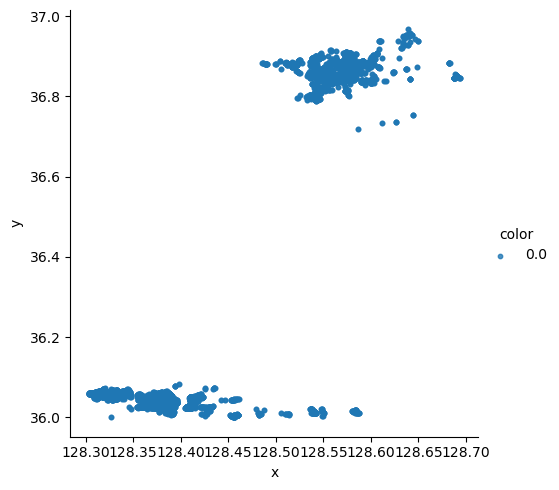

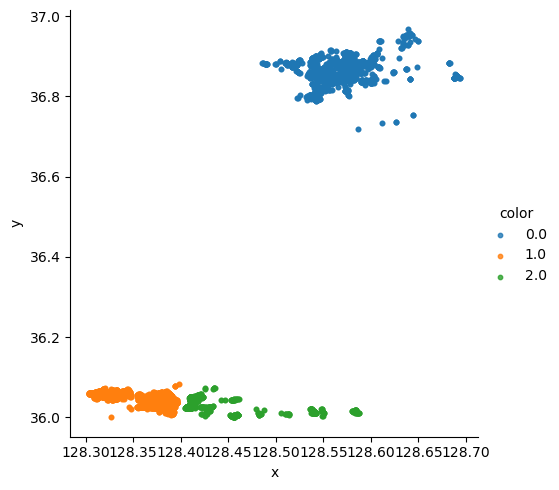

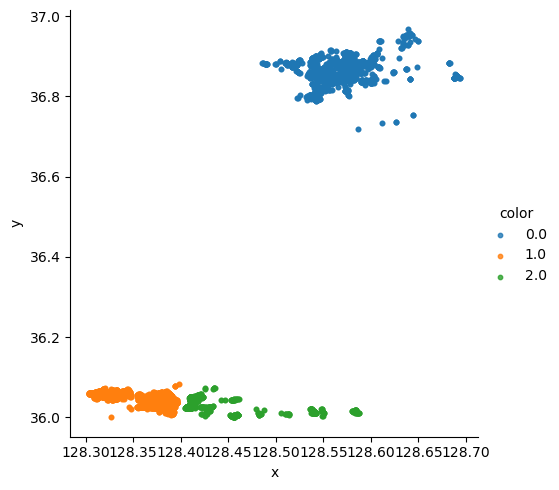

2018125042 이석준


In [6]:
#!/usr/bin/env python
# coding: utf-8
# 방법 5 클러스터링 중심을 차례대로 추가하는 방법
# In[1]:

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import csv
import time


# In[2]:


# Task Class based on "TaskID"
class Task(): 

    # add one ground with initiation
    def __init__(self, task_id, x, y, area): 
        self.x_array = np.empty(shape = (0), dtype = 'float64')
        self.y_array = np.empty(shape = (0), dtype = 'float64')
        self.area_array = np.empty(shape = (0), dtype = 'float64')

        self.taskid = task_id
        self.ground_count = 0
        self.ground_total_area = 0
        self.add_ground(x, y, area)

    # add Ground component
    def add_ground(self, x, y, area): 
        self.x_array = np.append(self.x_array, x)
        self.y_array = np.append(self.y_array, y)
        self.area_array = np.append(self.area_array, area)
        
        self.ground_count += 1
        self.ground_total_area += area

    def get_taskid(self):
        return self.taskid

    def get_ground_count(self):
        return self.ground_count

    def get_ground_total_area(self):
        return self.ground_total_area

    
    def print(self):
        print('TaskID:', self.taskid)
        #for i in range(0, self.ground_count):
        #    print('x: ', self.x_array[i], ' / y: ', self.y_array[i], ' / area: ', self.area_array[i])
        print('This Task has', self.ground_count, 'grounds.')
        print('Total area of this Task is:', self.ground_total_area, 'm^2')
        print('End of data.\n\n')


# In[3]:


class K_means():
    def __init__(self, Task, cycle = 10):
        self.cycle = cycle
        self.variation = -1.0

        self.k = 3
        self.data_size = Task.ground_count
        self.data_array = np.zeros(shape = (self.data_size, 4), dtype = 'float64')
        self.minimum_area = 33057.8512
        self.error_count = 0

        self.data_array[:, 0] = Task.x_array.copy()
        self.data_array[:, 1] = Task.y_array.copy()
        self.data_array[:, 2] = Task.area_array.copy()

        #self.old_centers = np.empty(shape = (self.k, 2), dtype = 'float64')
        self.old_total_area = np.empty(shape = (0), dtype = 'float64')

    def set_initial_points(self):
        self.centers = np.empty(shape=(self.k, 4), dtype='float64')
        

        first_point_idx = random.randrange(0, self.data_size)
        self.centers[0] = self.data_array[first_point_idx]

        for i in range(1, self.k):
            max_dist = -1
            max_dist_idx = -1

            for j in range(self.data_size):
                min_dist_to_center = np.inf
 
                for c in range(i):
                    dist_to_center = np.linalg.norm(self.data_array[j] - self.centers[c])
                    min_dist_to_center = min(min_dist_to_center, dist_to_center)

                if min_dist_to_center > max_dist:
                    max_dist = min_dist_to_center
                    max_dist_idx = j


            self.centers[i] = self.data_array[max_dist_idx]
    def clustering(self):
        for i in range(0, self.data_size):
            temp1 = -1.0
            record = 0
            for j in range(0, self.k):
                x = self.data_array[i][0]
                y = self.data_array[i][1]

                tx = self.centers[j][0]
                ty = self.centers[j][1]
                
                temp2 = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

                if temp1 == -1.0 or temp1 > temp2:
                    temp1 = temp2
                    record = j

            self.data_array[i][3] = record

    def center_adjusting(self):
        temp_array = np.zeros(shape = (self.k, 3), dtype = 'float64')

        #sum all of x and y value and count
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])

            temp_array[temp][0] += self.data_array[i][0]
            temp_array[temp][1] += self.data_array[i][1]
            temp_array[temp][2] += 1

        # devide all of x and y to count
        for i in range(0, self.k):
            #if one of groups has 0 count of ground.
            #means, that group has disappeared.
            count = temp_array[i][2]
            if not count:
                return -1  #error code
            temp_array[i][0] /= count
            temp_array[i][1] /= count

        flag = False
        for i in range(0, self.k): # compare that center has moved
            if temp_array[i][0] != self.centers[i][0]:
                flag = True
                break
            if temp_array[i][1] != self.centers[i][1]:
                flag = True
                break

        if flag: #if it moved
            for i in range(0, self.k):
                self.centers[i][0] = temp_array[i][0]
                self.centers[i][1] = temp_array[i][1]
            return 1

        else: #else
            return 0

    def adjust_total_area(self):
        #sum all total_area of each groups.
        self.total_area = np.zeros(shape = (self.k), dtype = 'float64')   
        for i in range(0, self.data_size):
            self.total_area[int(self.data_array[i][3])] += self.data_array[i][2]

        # make 2di_array of distance between all dots and centers.
        distance_array = np.empty(shape = (self.k, self.data_size), dtype = 'float64')
        for i in range(0, self.k):
            tx = self.centers[i][0]
            ty = self.centers[i][1]
            for j in range(0, self.data_size):
                x = self.data_array[j][0]
                y = self.data_array[j][1]
                                
                distance_array[i][j] = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        # READ (README FILE/class K_means) to get more info.
        marker_array = np.zeros(shape = (self.data_size), dtype = int)

        flag = True
        while flag:
            temp_array = self.total_area.copy()
            for i in range(0, self.k):
                if self.total_area[i] < self.minimum_area:
                    record1 = -1
                    record2 = -1
                    while self.total_area[i] < self.minimum_area:
                        temp1 = -1.0
                        for j in range(0, self.data_size):
                            if int(self.data_array[j][3]) != i:
                                if not marker_array[j]:
                                    temp2 = distance_array[i][j]
                                    if temp1 == -1.0 or temp1 > temp2:
                                        temp1 = temp2
                                        record1 = j
                            else:
                                marker_array[j] = 1
                                
                        record2 = int(self.data_array[record1][3])
                        self.data_array[record1][3] = i
                        self.total_area[i] += self.data_array[record1][2]
                        self.total_area[record2] -= self.data_array[record1][2]

                        marker_array[record1] = 1
                        
                    self.data_array[record1][3] = record2
                    self.total_area[i] -= self.data_array[record1][2]
                    self.total_area[record2] += self.data_array[record1][2]

                    marker_array[record1] = 0

            for i in range(0, self.k):
                if temp_array[i] != self.total_area[i]:
                    flag = True
                    break
                
                else:
                    flag = False

    def calculate_variation(self, field = False):
        all_sum = 0.0
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])
            
            x = self.data_array[i][0]
            y = self.data_array[i][1]
            tx = self.centers[temp][0]
            ty = self.centers[temp][1]

            all_sum += ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        #if variation had changed, return 1
        if (self.variation == -1.0) or (self.variation > all_sum):
            self.variation = all_sum

            if field:
                self.old_total_area = self.total_area.copy()
            return 1
        
        #else, return 0
        return 0

    # calculate variation of "real devided  info."
    def get_default_variation(self):
        self.variation = -1.0
        self.set_initial_points()
        self.center_adjusting()
        self.calculate_variation()
        return self.variation

    #normal k_means
    def random_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            self.set_initial_points()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear.
            if flag != -1:
                # if variation change has occured.
                if self.calculate_variation():
                    i = 0
                #else
                else:
                    i += 1
            else:
                self.error_count += 1

        self.error_count = 0
        print('Variation:', self.variation, '\nthis time cycle number is:', count)

    # special kmeans with "considering area need."
    def special_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            count += 1
            self.set_initial_points()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear. and there are more than 1group.
            if flag != -1 and self.k > 1:
                self.adjust_total_area()
                self.center_adjusting()
                # if variation change has occured.
                if self.calculate_variation(True):
                    i = 0
                #else
                else:
                    i += 1

        self.error_count = 0
        print('Group total area\n', self.old_total_area)
        print('\nVariation:', self.variation, '\nthis time cycle number is:', count)

    def get_x_array(self):
        return self.data_array[:, 0]
    
    def get_y_array(self):
        return self.data_array[:, 1]
    
    def get_group_array(self):
        return self.data_array[:, 3]
    
    def get_group_min_max_xy(self):
        # self.k rows
        # 4 columns (minX, minY, maxX, maxY)
        temp_array = np.zeros(shape = (self.k, 4), dtype = 'float64')
        for i in range(0, self.data_size):
            group_num = int(self.data_array[i, 3])
            if temp_array[group_num, 0] == 0:
                temp_array[group_num, 0] = self.data_array[i, 0]
                temp_array[group_num, 1] = self.data_array[i, 1]
                temp_array[group_num, 2] = self.data_array[i, 0]
                temp_array[group_num, 3] = self.data_array[i, 1]
                continue
            if temp_array[group_num, 0] > self.data_array[i, 0]:
                temp_array[group_num, 0] = self.data_array[i, 0]
            if temp_array[group_num, 1] > self.data_array[i, 1]:
                temp_array[group_num, 1] = self.data_array[i, 1]
            if temp_array[group_num, 2] < self.data_array[i, 0]:
                temp_array[group_num, 2] = self.data_array[i, 0]
            if temp_array[group_num, 3] < self.data_array[i, 1]:
                temp_array[group_num, 3] = self.data_array[i, 1]
                
        return temp_array


def read_csv(file_name):
    return_list = []
    
    f = open(file_name, 'r', encoding = 'utf-8')

    i = 0
    for row in csv.reader(f):
        if i == 0:
            i += 1
            continue

        flag = False
        taskid = 0
        try:
            x = float(row[0])
            y = float(row[1])
            area = float(row[2])
        except ValueError:
            print(f"Unable to convert to float: {row}")
            continue
            
        if x <= 129 and x >= 128 and y <= 37 and y >= 36:
            for task in return_list:
                if task.get_taskid() == taskid:
                    task.add_ground(x, y, area)
                    flag = True
                    break
            if not flag:
                return_list.append(Task(taskid, x, y, area))
            
        #if i == 1000:
        #    break
        i += 1
        
    print('Task set finished\n')

    return return_list


# In[5]:


task_list = []

task_list = read_csv('./sorted_data.csv')

f = open('result_sum.csv','a', newline='')
wr = csv.writer(f)

result_dict = {"Algorithm": "k-means"}
for task in task_list:
    kmeans = K_means(task)

    task.print()
    
    dv = kmeans.get_default_variation()
    print('This is default variation', dv)
    
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                        'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})
    
    print('\nRANDOM K_MEANS')
    start = time.time()
    kmeans.random_kmeans()
    time1 = time.time() - start
    print('it took', round(time1, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})

    print('\nSPECIAL K_MEANS')
    start = time.time()
    kmeans.special_kmeans()
    time2 = time.time() - start
    print('it took', round(time2, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
                scatter_kws = {"s": 10})

    plt.show(block = True)
    polygons = []
    for group_id in set(kmeans.get_group_array()):
        indices = np.where(kmeans.get_group_array() == group_id)
        polygons.append(
        list(zip(kmeans.get_x_array()[indices].tolist(), kmeans.get_y_array()[indices].tolist())))  # y coordinates

    result_dict[str(task.get_taskid())] = polygons
    print('========================================')

f.close()

with open('result.json', 'w') as fp:
    json.dump(result_dict, fp, indent=4)  # use indent=4 for pretty-printing



print("2018125042이석준")




Task set finished

TaskID: 0
This Task has 8456 grounds.
Total area of this Task is: 16621485.799999997 m^2
End of data.


This is default variation 3549.1111498602213

RANDOM K_MEANS
Variation: 13.541255871114311 
this time cycle number is: 0
it took 5.77 secs.
[[128.3033111   36.00001705 128.5877016   36.08277773]
 [128.4856161   36.71912276 128.6441689   36.89063013]
 [128.5375556   36.83423864 128.6936299   36.96697794]]

SPECIAL K_MEANS
Group total area
 [7390988.60000001 8545937.2         684560.        ]

Variation: 12.650702512556384 
this time cycle number is: 13
it took 5.275 secs.
[[128.3033111   36.00136268 128.3979671   36.08277773]
 [128.4041341   36.00001705 128.5877016   36.0721034 ]
 [128.4856161   36.71912276 128.6936299   36.96697794]]


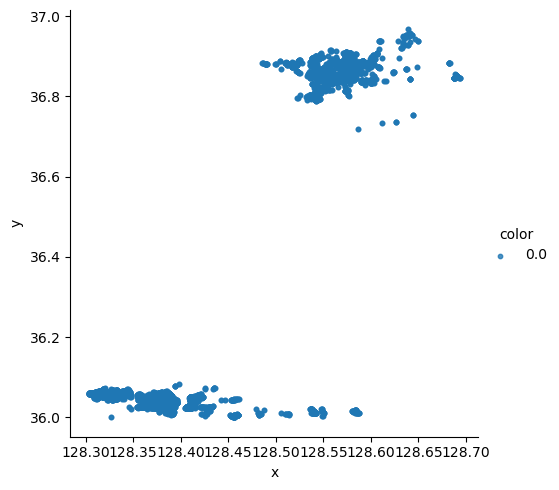

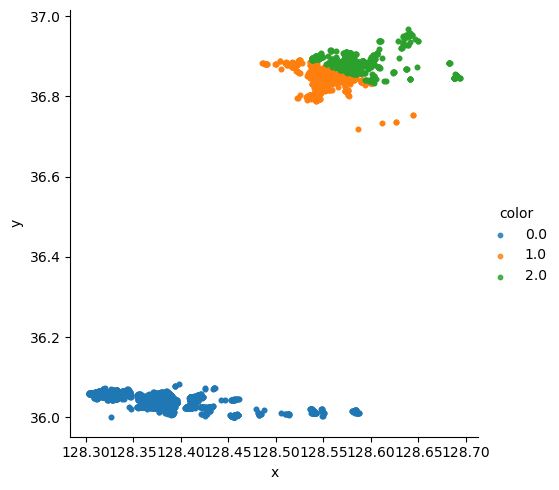

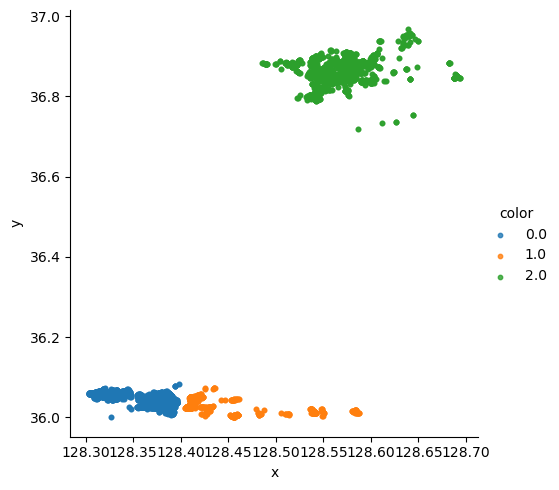

2017125054 이순용


In [7]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import csv
import time


# In[2]:


# Task Class based on "TaskID"
class Task(): 

    # add one ground with initiation
    def __init__(self, task_id, x, y, area): 
        self.x_array = np.empty(shape = (0), dtype = 'float64')
        self.y_array = np.empty(shape = (0), dtype = 'float64')
        self.area_array = np.empty(shape = (0), dtype = 'float64')

        self.taskid = task_id
        self.ground_count = 0
        self.ground_total_area = 0
        self.add_ground(x, y, area)

    # add Ground component
    def add_ground(self, x, y, area): 
        self.x_array = np.append(self.x_array, x)
        self.y_array = np.append(self.y_array, y)
        self.area_array = np.append(self.area_array, area)
        
        self.ground_count += 1
        self.ground_total_area += area

    def get_taskid(self):
        return self.taskid

    def get_ground_count(self):
        return self.ground_count

    def get_ground_total_area(self):
        return self.ground_total_area

    
    def print(self):
        print('TaskID:', self.taskid)
        #for i in range(0, self.ground_count):
        #    print('x: ', self.x_array[i], ' / y: ', self.y_array[i], ' / area: ', self.area_array[i])
        print('This Task has', self.ground_count, 'grounds.')
        print('Total area of this Task is:', self.ground_total_area, 'm^2')
        print('End of data.\n\n')


# In[3]:


class K_means():
    def __init__(self, Task, cycle = 10):
        self.cycle = cycle
        self.variation = -1.0

        self.k = 3
        self.data_size = Task.ground_count
        self.data_array = np.zeros(shape = (self.data_size, 4), dtype = 'float64')
        self.minimum_area = 33057.8512
        self.error_count = 0

        self.data_array[:, 0] = Task.x_array.copy()
        self.data_array[:, 1] = Task.y_array.copy()
        self.data_array[:, 2] = Task.area_array.copy()

        #self.old_centers = np.empty(shape = (self.k, 2), dtype = 'float64')
        self.old_total_area = np.empty(shape = (0), dtype = 'float64')

    def set_random_points(self):
        self.centers = np.empty(shape = (self.k, 2), dtype = 'float64')

        i = 0
        temp_list = []
        # there must not be duplicated centers.
        while i < self.k:
            flag = False
            temp = random.randrange(0, self.data_size)
            for j in temp_list: #if duplicated.
                if j == temp:
                    flag = True
                    break
            if not flag:
                temp_list.append(temp) #else
                i += 1

        i = 0
        for number in temp_list: # make centers array
            self.centers[i][0] = self.data_array[number][0]
            self.centers[i][1] = self.data_array[number][1]
            i += 1

    def clustering(self):
        for i in range(0, self.data_size):
            temp1 = -1.0
            record = 0
            for j in range(0, self.k):
                x = self.data_array[i][0]
                y = self.data_array[i][1]

                tx = self.centers[j][0]
                ty = self.centers[j][1]
                
                temp2 = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

                if temp1 == -1.0 or temp1 > temp2:
                    temp1 = temp2
                    record = j

            self.data_array[i][3] = record

    def center_adjusting(self):
        temp_array = np.zeros(shape = (self.k, 3), dtype = 'float64')

        #sum all of x and y value and count
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])

            temp_array[temp][0] += self.data_array[i][0]
            temp_array[temp][1] += self.data_array[i][1]
            temp_array[temp][2] += 1

        # devide all of x and y to count
        for i in range(0, self.k):
            #if one of groups has 0 count of ground.
            #means, that group has disappeared.
            count = temp_array[i][2]
            if not count:
                return -1  #error code
            temp_array[i][0] /= count
            temp_array[i][1] /= count

        flag = False
        for i in range(0, self.k): # compare that center has moved
            if temp_array[i][0] != self.centers[i][0]:
                flag = True
                break
            if temp_array[i][1] != self.centers[i][1]:
                flag = True
                break

        if flag: #if it moved
            for i in range(0, self.k):
                self.centers[i][0] = temp_array[i][0]
                self.centers[i][1] = temp_array[i][1]
            return 1

        else: #else
            return 0

    def adjust_total_area(self):
        #sum all total_area of each groups.
        self.total_area = np.zeros(shape = (self.k), dtype = 'float64')   
        for i in range(0, self.data_size):
            self.total_area[int(self.data_array[i][3])] += self.data_array[i][2]

        # make 2di_array of distance between all dots and centers.
        distance_array = np.empty(shape = (self.k, self.data_size), dtype = 'float64')
        for i in range(0, self.k):
            tx = self.centers[i][0]
            ty = self.centers[i][1]
            for j in range(0, self.data_size):
                x = self.data_array[j][0]
                y = self.data_array[j][1]
                                
                distance_array[i][j] = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        # READ (README FILE/class K_means) to get more info.
        marker_array = np.zeros(shape = (self.data_size), dtype = int)

        flag = True
        while flag:
            temp_array = self.total_area.copy()
            for i in range(0, self.k):
                if self.total_area[i] < self.minimum_area:
                    record1 = -1
                    record2 = -1
                    while self.total_area[i] < self.minimum_area:
                        temp1 = -1.0
                        for j in range(0, self.data_size):
                            if int(self.data_array[j][3]) != i:
                                if not marker_array[j]:
                                    temp2 = distance_array[i][j]
                                    if temp1 == -1.0 or temp1 > temp2:
                                        temp1 = temp2
                                        record1 = j
                            else:
                                marker_array[j] = 1
                                
                        record2 = int(self.data_array[record1][3])
                        self.data_array[record1][3] = i
                        self.total_area[i] += self.data_array[record1][2]
                        self.total_area[record2] -= self.data_array[record1][2]

                        marker_array[record1] = 1
                        
                    self.data_array[record1][3] = record2
                    self.total_area[i] -= self.data_array[record1][2]
                    self.total_area[record2] += self.data_array[record1][2]

                    marker_array[record1] = 0

            for i in range(0, self.k):
                if temp_array[i] != self.total_area[i]:
                    flag = True
                    break
                
                else:
                    flag = False

    def calculate_variation(self, field = False):
        all_sum = 0.0
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])
            
            x = self.data_array[i][0]
            y = self.data_array[i][1]
            tx = self.centers[temp][0]
            ty = self.centers[temp][1]

            all_sum += ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        #if variation had changed, return 1
        if (self.variation == -1.0) or (self.variation > all_sum):
            self.variation = all_sum

            if field:
                self.old_total_area = self.total_area.copy()
            return 1
        
        #else, return 0
        return 0

    # calculate variation of "real devided  info."
    def get_default_variation(self):
        self.variation = -1.0
        self.set_random_points()
        self.center_adjusting()
        self.calculate_variation()
        return self.variation

    #normal k_means
    def random_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            self.set_random_points()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear.
            if flag != -1:
                # if variation change has occured.
                if self.calculate_variation():
                    i = 0
                #else
                else:
                    i += 1
            else:
                self.error_count += 1

        self.error_count = 0
        print('Variation:', self.variation, '\nthis time cycle number is:', count)

    # special kmeans with "considering area need."
    def special_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            count += 1
            self.set_random_points()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear. and there are more than 1group.
            if flag != -1 and self.k > 1:
                self.adjust_total_area()
                self.center_adjusting()
                # if variation change has occured.
                if self.calculate_variation(True):
                    i = 0
                #else
                else:
                    i += 1

        self.error_count = 0
        print('Group total area\n', self.old_total_area)
        print('\nVariation:', self.variation, '\nthis time cycle number is:', count)

    def get_x_array(self):
        return self.data_array[:, 0]
    
    def get_y_array(self):
        return self.data_array[:, 1]
    
    def get_group_array(self):
        return self.data_array[:, 3]
    
    def get_group_min_max_xy(self):
        # self.k rows
        # 4 columns (minX, minY, maxX, maxY)
        temp_array = np.zeros(shape = (self.k, 4), dtype = 'float64')
        for i in range(0, self.data_size):
            group_num = int(self.data_array[i, 3])
            if temp_array[group_num, 0] == 0:
                temp_array[group_num, 0] = self.data_array[i, 0]
                temp_array[group_num, 1] = self.data_array[i, 1]
                temp_array[group_num, 2] = self.data_array[i, 0]
                temp_array[group_num, 3] = self.data_array[i, 1]
                continue
            if temp_array[group_num, 0] > self.data_array[i, 0]:
                temp_array[group_num, 0] = self.data_array[i, 0]
            if temp_array[group_num, 1] > self.data_array[i, 1]:
                temp_array[group_num, 1] = self.data_array[i, 1]
            if temp_array[group_num, 2] < self.data_array[i, 0]:
                temp_array[group_num, 2] = self.data_array[i, 0]
            if temp_array[group_num, 3] < self.data_array[i, 1]:
                temp_array[group_num, 3] = self.data_array[i, 1]
                
        return temp_array


# In[4]:


def read_csv(file_name):
    return_list = []
    
    f = open(file_name, 'r', encoding = 'utf-8')

    i = 0
    for row in csv.reader(f):
        if i == 0:
            i += 1
            continue

        flag = False
        taskid = 0
        x = float(row[0])
        y = float(row[1])
        area = float(row[2])
        if x <= 129 and x >= 128 and y <= 37 and y >= 36:
            for task in return_list:
                if task.get_taskid() == taskid:
                    task.add_ground(x, y, area)
                    flag = True
                    break
            if not flag:
                return_list.append(Task(taskid, x, y, area))
            
        #if i == 1000:
        #    break
        i += 1
        
    print('Task set finished\n')

    return return_list


# In[5]:


task_list = []

task_list = read_csv('./sorted_data.csv')

f = open('result_sum.csv','a', newline='')
wr = csv.writer(f)

for task in task_list:
    kmeans = K_means(task)

    task.print()
    
    dv = kmeans.get_default_variation()
    print('This is default variation', dv)
    
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                        'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})
    
    print('\nRANDOM K_MEANS')
    start = time.time()
    kmeans.random_kmeans()
    time1 = time.time() - start
    print('it took', round(time1, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})

    print('\nSPECIAL K_MEANS')
    start = time.time()
    kmeans.special_kmeans()
    time2 = time.time() - start
    print('it took', round(time2, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
                scatter_kws = {"s": 10})

    plt.show(block = True)

    print('========================================')

f.close()


# In[6]:


print("2017125054 이순용")



In [ ]:
#!/usr/bin/env python
# coding: utf-8



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import csv
import time


class Task(): 

    # add one ground with initiation
    def __init__(self, task_id, x, y, area): 
        self.x_array = np.empty(shape = (0), dtype = 'float64')
        self.y_array = np.empty(shape = (0), dtype = 'float64')
        self.area_array = np.empty(shape = (0), dtype = 'float64')

        self.taskid = task_id
        self.ground_count = 0
        self.ground_total_area = 0
        self.add_ground(x, y, area)

    # add Ground component
    def add_ground(self, x, y, area): 
        self.x_array = np.append(self.x_array, x)
        self.y_array = np.append(self.y_array, y)
        self.area_array = np.append(self.area_array, area)
        
        self.ground_count += 1
        self.ground_total_area += area

    def get_taskid(self):
        return self.taskid

    def get_ground_count(self):
        return self.ground_count

    def get_ground_total_area(self):
        return self.ground_total_area

    
    def print(self):
        print('TaskID:', self.taskid)
        #for i in range(0, self.ground_count):
        #    print('x: ', self.x_array[i], ' / y: ', self.y_array[i], ' / area: ', self.area_array[i])
        print('This Task has', self.ground_count, 'grounds.')
        print('Total area of this Task is:', self.ground_total_area, 'm^2')
        print('End of data.\n\n')


class DBSCANCluster:
    UNCLASSIFIED = False
    NOISE = -1 
    def __init__(self, m, eps, min_points):
        self.m = m
        self.eps = eps
        self.min_points = min_points
        # Change self.m.shape[1] to self.m.shape[0] to match the number of samples in the dataset
        self.classifications = [self.UNCLASSIFIED] * self.m.shape[0]
        self.classifications_list = {}

    def _dist(self, p, q):
        return math.sqrt(np.power(p - q, 2).sum())

    def _eps_neighborhood(self, p, q, eps):
        return self._dist(p, q) < eps
    
    def _expand_cluster(self, point_id, cluster_id):
        seeds = self._region_query(point_id)
        if len(seeds) < self.min_points:
            self.classifications[point_id] = self.NOISE  # classify as noise
            return False
        else:
            self.classifications[point_id] = cluster_id
            self.classifications_list[cluster_id] = seeds
            return True

    def _region_query(self, point_id):
        n_points = self.m.shape[0]  # Change self.m.shape[1] to self.m.shape[0] to match the number of samples in the dataset
        seeds = []
        for i in range(0, n_points):
            if self._eps_neighborhood(self.m[point_id, :], self.m[i, :], self.eps):  # use self.m[point_id, :] and self.m[i, :] to represent points
                seeds.append(i)
        return seeds

    def _expand_cluster(self, point_id, cluster_id):
        seeds = self._region_query(point_id)
        if len(seeds) < self.min_points:
            self.classifications[point_id] = self.NOISE
            return False
        else:
            self.classifications[point_id] = cluster_id
            self.classifications_list[cluster_id] = seeds
            return True

    def apply(self):
        cluster_id = 1
        for point_id in range(0, self.m.shape[0]):  # Change self.m.shape[1] to self.m.shape[0] to match the number of samples in the dataset
            if self.classifications[point_id] == self.UNCLASSIFIED:
                if self._expand_cluster(point_id, cluster_id):
                    cluster_id += 1
        return self.classifications

    def get_core_samples_indices(self):
        core_samples_indices = []
        for cluster_id, points in self.classifications_list.items():
            core_samples_indices.extend(points)
        return core_samples_indices

    def get_labels(self):
        return self.classifications


class K_means():
    def __init__(self, Task, cycle = 10, eps=0.00006, min_points=5):
        self.cycle = cycle
        self.variation = -1.0
        self.eps = eps  # Added this line
        self.min_points = min_points 
        self.k = 3
        self.data_size = Task.ground_count
        self.data_array = np.zeros(shape = (self.data_size, 4), dtype = 'float64')
        self.minimum_area = 33057.8512
        self.error_count = 0

        self.data_array[:, 0] = Task.x_array.copy()
        self.data_array[:, 1] = Task.y_array.copy()
        self.data_array[:, 2] = Task.area_array.copy()

        #self.old_centers = np.empty(shape = (self.k, 2), dtype = 'float64')
        self.old_total_area = np.empty(shape = (0), dtype = 'float64')

    def set_centers_from_dbscan(self):
        data = self.data_array[:, :2]
        dbscan = DBSCANCluster(data, eps=self.eps, min_points=self.min_points)
        self.groups = dbscan.apply()  # Set self.groups
        core_samples_mask = np.zeros_like(self.groups, dtype=bool)
        core_samples_mask[dbscan.get_core_samples_indices()] = True
        unique_labels = set(self.groups)
        self.centers = []
        for k in unique_labels:
            if k == DBSCANCluster.NOISE:  # skip the noise cluster
                continue
            class_member_mask = (self.groups == k)
            xy = self.data_array[class_member_mask & core_samples_mask, :2]
            if len(xy) > 0:
                center = xy.mean(axis=0)
                self.centers.append(center)
            else:
                print(f"클러스터가 아닌 점: {k}. Skipping...")



    def clustering(self):
        for i in range(0, self.data_size):
            min_dist = float('inf')
            nearest_center = -1

            x = self.data_array[i][0]
            y = self.data_array[i][1]

        for j in range(len(self.centers)): # ensure j is within the range of self.centers
            tx = self.centers[j][0]
            ty = self.centers[j][1]

            distance = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))
            if min_dist > distance:
                min_dist = distance
                nearest_center = j

        if nearest_center != -1: # this check will make sure that we are assigning a valid center
            self.data_array[i][3] = nearest_center


    def center_adjusting(self):
        temp_array = np.zeros(shape = (self.k, 3), dtype = 'float64')

        #sum all of x and y value and count
        for i in range(0, self.data_size):
            temp = int(self.data_array[i][3])

            temp_array[temp][0] += self.data_array[i][0]
            temp_array[temp][1] += self.data_array[i][1]
            temp_array[temp][2] += 1

        # devide all of x and y to count
        for i in range(0, self.k):
            #if one of groups has 0 count of ground.
            #means, that group has disappeared.
            count = temp_array[i][2]
            if not count:
                return -1  #error code
            temp_array[i][0] /= count
            temp_array[i][1] /= count

        flag = False
        for i in range(0, self.k): # compare that center has moved
            if temp_array[i][0] != self.centers[i][0]:
                flag = True
                break
            if temp_array[i][1] != self.centers[i][1]:
                flag = True
                break

        if flag: #if it moved
            for i in range(0, self.k):
                self.centers[i][0] = temp_array[i][0]
                self.centers[i][1] = temp_array[i][1]
            return 1

        else: #else
            return 0

    def adjust_total_area(self):
        #sum all total_area of each groups.
        self.total_area = np.zeros(shape = (self.k), dtype = 'float64')   
        for i in range(0, self.data_size):
            self.total_area[int(self.data_array[i][3])] += self.data_array[i][2]

        # make 2di_array of distance between all dots and centers.
        distance_array = np.empty(shape = (self.k, self.data_size), dtype = 'float64')
        for i in range(0, self.k):
            tx = self.centers[i][0]
            ty = self.centers[i][1]
            for j in range(0, self.data_size):
                x = self.data_array[j][0]
                y = self.data_array[j][1]
                                
                distance_array[i][j] = ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        # READ (README FILE/class K_means) to get more info.
        marker_array = np.zeros(shape = (self.data_size), dtype = int)

        flag = True
        while flag:
            temp_array = self.total_area.copy()
            for i in range(0, self.k):
                if self.total_area[i] < self.minimum_area:
                    record1 = -1
                    record2 = -1
                    while self.total_area[i] < self.minimum_area:
                        temp1 = -1.0
                        for j in range(0, self.data_size):
                            if int(self.data_array[j][3]) != i:
                                if not marker_array[j]:
                                    temp2 = distance_array[i][j]
                                    if temp1 == -1.0 or temp1 > temp2:
                                        temp1 = temp2
                                        record1 = j
                            else:
                                marker_array[j] = 1
                                
                        record2 = int(self.data_array[record1][3])
                        self.data_array[record1][3] = i
                        self.total_area[i] += self.data_array[record1][2]
                        self.total_area[record2] -= self.data_array[record1][2]

                        marker_array[record1] = 1
                        
                    self.data_array[record1][3] = record2
                    self.total_area[i] -= self.data_array[record1][2]
                    self.total_area[record2] += self.data_array[record1][2]

                    marker_array[record1] = 0

            for i in range(0, self.k):
                if temp_array[i] != self.total_area[i]:
                    flag = True
                    break
                
                else:
                    flag = False

    def calculate_variation(self, field = False):
        all_sum = 0.0
        for i in range(0, self.data_size):
            temp = int(self.groups[i]) - 1 # self.groups is more meaningful and adjust index for zero-based array

            if temp >= 0 and temp < len(self.centers): # check if temp is within valid range
                x = self.data_array[i][0]
                y = self.data_array[i][1]
                tx = self.centers[temp][0]
                ty = self.centers[temp][1]

                all_sum += ((tx - x) * (tx - x)) + ((ty - y) * (ty - y))

        #if variation had changed, return 1
        if (self.variation == -1.0) or (self.variation > all_sum):
            self.variation = all_sum

            if field:
                self.old_total_area = self.total_area.copy()
            return 1

        #else, return 0
        return 0

    # calculate variation of "real devided  info."
    def get_default_variation(self):
        self.variation = -1.0
        self.set_centers_from_dbscan()
        self.center_adjusting()
        self.calculate_variation()
        return self.variation

    #normal k_means
    def random_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            self.set_centers_from_dbscan()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear.
            if flag != -1:
                # if variation change has occured.
                if self.calculate_variation():
                    i = 0
                #else
                else:
                    i += 1
            else:
                self.error_count += 1

        self.error_count = 0
        print('Variation:', self.variation, '\nthis time cycle number is:', count)

    # special kmeans with "considering area need."
    def special_kmeans(self):
        i = 0
        count = 0
        self.variation = -1.0
        while i < self.cycle:
            if self.error_count >= 100:
                print("error return")
                return
            #print(i)
            count += 1
            self.set_centers_from_dbscan()
            self.clustering()

            flag = 1
            while flag == 1: # while centers dont move anymore
                flag = self.center_adjusting()
                self.clustering()

            # if one of group didnt disappear. and there are more than 1group.
            if flag != -1 and self.k > 1:
                self.adjust_total_area()
                self.center_adjusting()
                # if variation change has occured.
                if self.calculate_variation(True):
                    i = 0
                #else
                else:
                    i += 1

        self.error_count = 0
        print('Group total area\n', self.old_total_area)
        print('\nVariation:', self.variation, '\nthis time cycle number is:', count)

    def get_x_array(self):
        return self.data_array[:, 0]
    
    def get_y_array(self):
        return self.data_array[:, 1]
    
    def get_group_array(self):
        return self.data_array[:, 3]
    
    def get_group_min_max_xy(self):
        # self.k rows
        # 4 columns (minX, minY, maxX, maxY)
        temp_array = np.zeros(shape = (self.k, 4), dtype = 'float64')
        for i in range(0, self.data_size):
            group_num = int(self.data_array[i, 3])
            if temp_array[group_num, 0] == 0:
                temp_array[group_num, 0] = self.data_array[i, 0]
                temp_array[group_num, 1] = self.data_array[i, 1]
                temp_array[group_num, 2] = self.data_array[i, 0]
                temp_array[group_num, 3] = self.data_array[i, 1]
                continue
            if temp_array[group_num, 0] > self.data_array[i, 0]:
                temp_array[group_num, 0] = self.data_array[i, 0]
            if temp_array[group_num, 1] > self.data_array[i, 1]:
                temp_array[group_num, 1] = self.data_array[i, 1]
            if temp_array[group_num, 2] < self.data_array[i, 0]:
                temp_array[group_num, 2] = self.data_array[i, 0]
            if temp_array[group_num, 3] < self.data_array[i, 1]:
                temp_array[group_num, 3] = self.data_array[i, 1]
                
        return temp_array



def read_csv(file_name):
    return_list = []
    
    f = open(file_name, 'r', encoding = 'utf-8')

    i = 0
    for row in csv.reader(f):
        if i == 0:
            i += 1
            continue

        flag = False
        taskid = 0
        x = float(row[0])
        y = float(row[1])
        area = float(row[2])
        if x <= 129 and x >= 128 and y <= 37 and y >= 36:
            for task in return_list:
                if task.get_taskid() == taskid:
                    task.add_ground(x, y, area)
                    flag = True
                    break
            if not flag:
                return_list.append(Task(taskid, x, y, area))
            
        #if i == 1000:
        #    break
        i += 1
        
    print('Task set finished\n')

    return return_list



task_list = []

task_list = read_csv('./sorted_data.csv')

f = open('result_sum.csv','a', newline='')
wr = csv.writer(f)

for task in task_list:
    kmeans = K_means(task)

    task.print()
    
    dv = kmeans.get_default_variation()
    print('This is default variation', dv)
    
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                        'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})
    
    print('\nRANDOM K_MEANS')
    start = time.time()
    kmeans.random_kmeans()
    time1 = time.time() - start
    print('it took', round(time1, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
               scatter_kws = {"s": 10})

    print('\nSPECIAL K_MEANS')
    start = time.time()
    kmeans.special_kmeans()
    time2 = time.time() - start
    print('it took', round(time2, 3), 'secs.')
    print(kmeans.get_group_min_max_xy())
    df = pd.DataFrame({'x': kmeans.get_x_array(),
                       'y': kmeans.get_y_array(),
                        'color': kmeans.get_group_array()})
    sns.lmplot(x = 'x', y = 'y',
               hue = 'color', data = df,
               fit_reg = False,
                scatter_kws = {"s": 10})

    plt.show(block = True)

    print('========================================')

f.close()



print("2018125042 이석준")

Task set finished

TaskID: 0
This Task has 8456 grounds.
Total area of this Task is: 16621485.799999997 m^2
End of data.


This is default variation 0.0

RANDOM K_MEANS
